In [1]:
import numpy as np 
import pandas as pd 
import os
import pickle
import sys
import torch
from torch import nn
import scipy
import torch.nn.functional as Func
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append("/kaggle/input/pytorch-sklearnn")
from pytorch_sklearn import NeuralNetwork
from pytorch_sklearn.callbacks import WeightCheckpoint, Verbose, LossPlot, EarlyStopping, Callback, CallbackInfo
from pytorch_sklearn.utils.func_utils import to_safe_tensor

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def read_data(path):
    with open(path, "rb") as f:
        return pickle.load(f)

In [5]:
DATASET_PATH = '/kaggle/input/arrythmia-dataset/dataset_training/dataset_beat_single_domain_adapted'
TRIO_PATH = '/kaggle/input/arrythmia-dataset/dataset_training/dataset_beat_trios_domain_adapted'
DICT_PATH = '/kaggle/input/dictionaries/dictionaries/dictionaries_5min_beats_single_sorted'

In [6]:
SAVE_PATH = '/kaggle/working/'
save_dir = os.path.join(SAVE_PATH, "nets")
os.makedirs(save_dir, exist_ok=True)

In [7]:
def load_dataset(patient_id, PATH):
    """ 
    Reads the pickled ECG dataset from the given path for the given patient.
    The file name must be "patient_<patient_id>_dataset.pkl".
    """
    with open(os.path.join(PATH, f"patient_{patient_id}_dataset.pkl"), "rb") as f:
        return pickle.load(f)

def load_dictionary(patient_id, PATH):
    """
    Reads the pickled ECG dictionary from the given path for the given patient.
    The file name must be "patient_<patient_id>_dictionary.pkl".
    """
    with open(os.path.join(PATH, f"patient_{patient_id}_dictionary.pkl"), "rb") as f:
        D = pickle.load(f)
        F = scipy.linalg.null_space(D.T)
        F = scipy.linalg.orth(F).T
    return D, F

    
def dataset_to_tensors(dataset):
    """
    Converts the given dataset to torch tensors in appropriate data types and shapes.
    """
    dataset = dataset.copy()
    train_X, train_y, train_ids, val_X, val_y, val_ids, test_X, test_y, test_ids = dataset.values()
    dataset["train_X"] = torch.Tensor(train_X).float().reshape(-1, 1, train_X.shape[1])
    dataset["train_y"] = torch.Tensor(train_y).long()
    dataset["train_ids"] = torch.Tensor(train_ids).long()
    dataset["val_X"] = torch.Tensor(val_X).float().reshape(-1, 1, val_X.shape[1])
    dataset["val_y"] = torch.Tensor(val_y).long()
    dataset["val_ids"] = torch.Tensor(val_ids).long()
    dataset["test_X"] = torch.Tensor(test_X).float().reshape(-1, 1, test_X.shape[1])
    dataset["test_y"] = torch.Tensor(test_y).long()
    dataset["test_ids"] = torch.Tensor(test_ids).long()
    return dataset

def add_dataset(patient_id, dataset, DATASET_PATH):
    """
    Adds another dataset to an already existing one, increasing the number of channels.
    """
    dataset = dataset.copy()
    dataset_other = load_dataset(patient_id, DATASET_PATH)
    dataset_other = dataset_to_tensors(dataset_other)
    
    assert torch.equal(dataset["train_y"], dataset_other["train_y"]), "Training ground truths are different. Possibly shuffled differently."
    assert torch.equal(dataset["val_y"], dataset_other["val_y"]), "Validation ground truths are different. Possibly shuffled differently."
    assert torch.equal(dataset["test_y"], dataset_other["test_y"]), "Test ground truths are different. Possibly shuffled differently."
    
    train_X, train_y, train_ids, val_X, val_y, val_ids, test_X, test_y, test_ids = dataset.values()
    train_other_X, _, _, val_other_X, _, _, test_other_X, _, _ = dataset_other.values()
    dataset["train_X"] = torch.cat((train_X, train_other_X), dim=1)
    dataset["val_X"] = torch.cat((val_X, val_other_X), dim=1)
    dataset["test_X"] = torch.cat((test_X, test_other_X), dim=1)
    return dataset

def load_N_channel_dataset(patient_id, DEFAULT_PATH, *PATHS):
    """
    Loads the ECG dataset at the given path(s) for the given patient. Each dataset will be added as a new
    channel in the given order.
    """
    default_dataset = load_dataset(patient_id, DEFAULT_PATH)
    default_dataset = dataset_to_tensors(default_dataset)
    for PATH in PATHS:
        default_dataset = add_dataset(patient_id, default_dataset, PATH)
    return default_dataset

In [8]:
def get_error_one_patient(S, F, y=None, as_energy=False):
    """
    Returns the error, E = S @ F.T
    
    Parameters
    ----------
    S : array_like
        ECG signals of shape (N x K), where K is signal length.
    F : array_like
        Dictionary null-space of shape (M x K), where M is error signal length.
    y : array_like
        Array of labels of shape (N). If provided, errors are returned separately for healthy and arrhythmia.
    as_energy : bool
        If True, error energies are returned instead.
    """
    
    assert F.shape[1] == S.shape[1], f"F and S can't be matrix multiplied. Provide S as a matrix with shape (N x {F.shape[1]})."
    assert y is None or len(np.unique(y)) == 2, f"There must be 2 classes. Found {len(np.unique(y))} classes."
    
    E = S @ F.T
    
    if as_energy:
        E = E.pow(2).sum(dim=1)
    
    if y is not None:
        healthy = np.where(y == 0)[0]
        arrhyth = np.where(y == 1)[0]

        E_healthy = E[healthy]
        E_arrhyth = E[arrhyth]
        
        return E, E_healthy, E_arrhyth
    return E

def get_error_per_patient(S, ids, DICT_PATH, y=None, as_energy=False):
    """
    Returns the error, E = S_i @ F_i.T, where S_i and F_i are the signals and null-space of patient i.
    
    Parameters
    ----------
    S : array_like
        ECG signals of shape (N x K), where K is signal length.
    ids : array_like
        ids[i] is the id of the patient that S[i] belongs to.
    DICT_PATH : str
        Path to the folder that has the dictionary of the users.
    y : array_like
        Array of labels of shape (N). If provided, errors are returned separately for healthy and arrhythmia.
    as_energy : bool
        If True, error energies are returned instead.
    """
    
    _, F = load_dictionary(ids[0], DICT_PATH)
    F = torch.Tensor(F).float()
    E_shape = S.shape[0] if as_energy else [S.shape[0], F.shape[0]]
    Es = torch.empty(E_shape)
    
    for id_ in ids.unique():
        _, F = load_dictionary(id_, DICT_PATH)
        F = torch.Tensor(F).float()
        idx = np.where(ids == id_)[0]
        E = get_error_one_patient(S[ids == id_], F, as_energy=as_energy)
        Es[idx] = E
    
    if y is not None:
        healthy = np.where(y == 0)[0]
        arrhyth = np.where(y == 1)[0]

        E_healthy = Es[healthy]
        E_arrhyth = Es[arrhyth]
        
        return Es, E_healthy, E_arrhyth
    
    return Es

In [9]:
class ExponentialFit:
    def __init__(self):
        pass
    
    def fit(self, X):
        self.beta = X.mean()
        self.fit_perf = np.sum(self.likelihood(X))
    
    def likelihood(self, X):
        return scipy.stats.expon(scale=self.beta).pdf(X)

class GaussianFit:
    def __init__(self):
        pass
    
    def fit(self, X):
        self.mu = X.mean()
        self.std = X.std()
        self.fit_perf = np.sum(self.likelihood(X))
    
    def likelihood(self, X):
        return scipy.stats.norm(loc=self.mu, scale=self.std).pdf(X)


class BayesianFit:
    def __init__(self):
        pass
        
    def predict(self, X, model1, model2, prior1=1, prior2=1):
        like1 = model1.likelihood(X) * prior1
        like2 = model2.likelihood(X) * prior2
        odd1 = like1 / like2
        return odd1 / (1 + odd1)

In [10]:
def get_performance_metrics(cm):
    """
    Calculates:
        accuracy
        true positive rate (recall, sensitivity)
        specificity (1 - false positive rate)
        positive predictive value (PPV, precision)
        negative predictive value (NPV)
        F1-score
    from the given confusion matrix.
    """
    cm = np.asarray(cm).copy()
    tp, fp, tn, fn = cm[0,0], cm[0,1], cm[1,1], cm[1,0]
    acc = (tp + tn) / (tp + tn + fp + fn)
    rec = tp / (tp + fn)
    spe = tn / (tn + fp)
    pre = tp / (tp + fp)
    npv = tn / (tn + fn)
    f1 = (2 * pre * rec) / (pre + rec)
    metrics = {"acc":acc, "rec":rec, "spe":spe, "pre":pre, "npv":npv, "f1":f1}
    return metrics

def get_confusion_matrix(pred_y, true_y, pos_is_zero=False):
    """
    Calculates the confusion matrix for the given predictions and truth values. 
    
    Set pos_is_zero to True if the positive sample's class index is 0.
    In the case of our ECG work, positive means an abnormal beat, and has a class index of 1.
    """
    pred_y = torch.as_tensor(pred_y, dtype=torch.long)
    true_y = torch.as_tensor(true_y, dtype=torch.long)
    vals = true_y + 2 * pred_y   # 0,0 -> 0    1,0 -> 1    0,1 -> 2    1,1 -> 3
    cm = torch.zeros(4).long()  
    cm += torch.bincount(vals, minlength=4)
    cm = cm.reshape(2, 2)
    
    if not pos_is_zero:
        return cm.flip((0, 1))
    return cm

In [11]:
def get_base_model(in_channels):
    """
    Returns the model from paper: Personalized Monitoring and Advance Warning System for Cardiac Arrhythmias.
    """
    # Input size: 128x1
    # 128x1 -> 122x32 -> 40x32 -> 34x16 -> 11x16 -> 5x16 -> 1x16
    model = nn.Sequential(
        nn.Conv1d(in_channels, 32, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),
        
        nn.Conv1d(32, 16, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),
        
        nn.Conv1d(16, 16, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),
        
        nn.Flatten(),
        
        nn.Linear(16, 32, bias=True),
        nn.ReLU(),
        
        nn.Linear(32, 2, bias=True),
    )
    return model

In [12]:
max_epochs = [-1]
batch_sizes = [1024]
confidences = [0, *np.linspace(0.5, 1, 51)]

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [14]:
target_patient_id = 124

In [15]:
dataset = load_N_channel_dataset(target_patient_id, DATASET_PATH, TRIO_PATH)
train_X, train_y, train_ids, val_X, val_y, val_ids, test_X, test_y, test_ids = dataset.values()

D, F = load_dictionary(target_patient_id, DICT_PATH)
D, F = torch.Tensor(D), torch.Tensor(F)

BF = BayesianFit()
EF = ExponentialFit()
GF = GaussianFit()

train_E, E_healthy, E_arrhyth = get_error_one_patient(train_X[:, 0, :].squeeze(), F, y=train_y, as_energy=True)
EF.fit(E_healthy)
GF.fit(E_arrhyth)
consult_train_y = torch.Tensor(BF.predict(train_E, EF, GF) <= 0.5).long()

val_E, val_E_healthy, val_E_arrhyth = get_error_one_patient(val_X[:, 0, :].squeeze(), F, y=val_y, as_energy=True)
EF.fit(val_E_healthy)
GF.fit(val_E_arrhyth)
consult_val_y = torch.Tensor(BF.predict(val_E, EF, GF) <= 0.5).long()

test_E = get_error_one_patient(test_X[:, 0, :].squeeze(), F, as_energy=True)
EF.fit(E_healthy)
GF.fit(E_arrhyth)
consult_test_y = torch.Tensor(BF.predict(test_E, EF, GF) <= 0.5).long()

model = get_base_model(in_channels=train_X.shape[1])
model = model.to(device)
crit = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(params=model.parameters())

net = NeuralNetwork(model, optim, crit)

weight_checkpoint_val_loss = WeightCheckpoint(tracked="val_loss", mode="min")
early_stopping = EarlyStopping(tracked="val_loss", mode="min", patience=15)

net.fit(
    train_X=train_X,
    train_y=train_y,
    validate=True,
    val_X=val_X,
    val_y=val_y,
    max_epochs=max_epochs[0],
    batch_size=batch_sizes[0],
    use_cuda=True,
    fits_gpu=True,
    callbacks=[weight_checkpoint_val_loss, early_stopping],
)


repeat_index = 0  
weight_path = os.path.join(save_dir, f"net_{repeat_index+1}_{target_patient_id}.pt")

NeuralNetwork.save_class(net, weight_path)

model = get_base_model(in_channels=train_X.shape[1])
model = model.to(device)
crit = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(params=model.parameters())

# Load the class using the same architecture
net = NeuralNetwork.load_class(
    weight_path,
    module=model,
    optimizer=optim,
    criterion=crit
)





pred_y = net.predict(val_X, batch_size=1024, use_cuda=True, fits_gpu=True, decision_func=lambda pred_y: pred_y.argmax(dim=1)).cpu()
prob_y = net.predict_proba(val_X).cpu()
softmax_prob_y = Func.softmax(prob_y, dim=1).max(dim=1).values

maxF1 = float("-inf")
maxConf = -1
for conf in confidences:
    low_confidence = softmax_prob_y < conf
    high_confidence = softmax_prob_y >= conf
    final_pred_y = torch.Tensor(np.select([low_confidence, high_confidence], [consult_val_y, pred_y])).long()
    val_cm = get_confusion_matrix(final_pred_y, val_y, pos_is_zero=False)
    f1 = get_performance_metrics(val_cm)["f1"]
    if f1 >= (maxF1 - 1e-3):
        maxF1 = f1
        maxConf = conf

pred_y = net.predict(test_X, batch_size=1024, use_cuda=True, fits_gpu=True, decision_func=lambda pred_y: pred_y.argmax(dim=1)).cpu()
prob_y = net.predict_proba(test_X).cpu()
softmax_prob_y = Func.softmax(prob_y, dim=1).max(dim=1).values

low_confidence = softmax_prob_y < maxConf
high_confidence = softmax_prob_y >= maxConf
final_pred_y = torch.Tensor(np.select([low_confidence, high_confidence], [consult_test_y, pred_y])).long()

# Get test confusion matrix
cm_exp = get_confusion_matrix(final_pred_y, test_y, pos_is_zero=False)

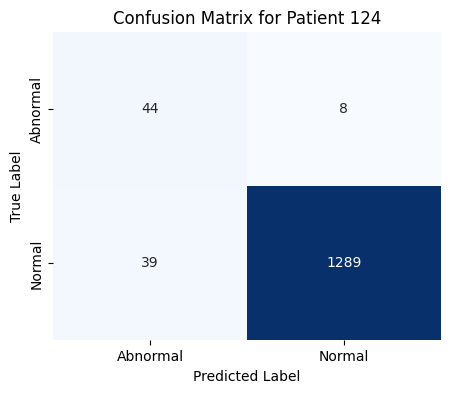

Confidence Threshold used: 0.85


In [16]:
FN, FP = cm_exp[0]
TN, TP = cm_exp[1]

cm = [[FN, FP], [TN, TP]]

fig, ax = plt.subplots(figsize=(5, 4))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Abnormal", "Normal"], yticklabels=["Abnormal", "Normal"], ax=ax)

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

plt.title(f"Confusion Matrix for Patient {target_patient_id}")
plt.show()

print(f"Confidence Threshold used: {maxConf:.2f}")
